In [1]:
from db import databaseconnection as dbc
from db import databaseconnectionDEPRECATED as dbd
import numpy as np
from ga import networkedgeneticalgorithm as nga
from membranesimulation import MembraneSimulation
import nanoparticle
from nanoparticle import Ligand, NanoParticle
import math
import parlammps
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import networkx
from tools import vectools
import os
import tools
import copy
import random
import pprint
import time
import pandas as pd
import holoviews as hv
import seaborn as sns
import pygraphviz
from pythreejs import *
from IPython.display import display
from ipywidgets import HTML, Text, Output, VBox
from traitlets import link, dlink
import k3d


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
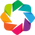

In [85]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('seaborn-deep')
pp = pprint.PrettyPrinter(indent=4)
hv.extension('bokeh','matplotlib')
%output widgets='live' holomap='scrubber'
%opts GridSpace [shared_xaxis=True shared_yaxis=True]
fAll = []
hsv = plt.get_cmap('hsv')
cool = plt.get_cmap('cool')

In [3]:
dbconn = dbc.DatabaseConnection('/Users/joelforster/Projects/optidb/july/6-24/datastore.db')
session = dbconn.getLastSession()
individuals = session.getIndividualsList()

/Users/joelforster/anaconda2/lib/python2.7/site-packages/sqlalchemy/sql/sqltypes.py:603: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [4]:
def greatArcDist(Ang1, Ang2, rad=4):
    #Ang = (PolarAng,AziAng)
    #https://math.stackexchange.com/questions/231221/great-arc-distance-between-two-points-on-a-unit-sphere
    arcDist=rad*(np.arccos((np.cos(Ang1[0])*np.cos(Ang2[0]))+((np.sin(Ang1[0])*np.sin(Ang2[0]))*(np.cos(Ang1[1]-Ang2[1])))))
    return arcDist

In [5]:
#fitness given genome
def genomeFitness(genome):
    for individual in individuals:
        if np.array_equal(individual.genomePickle, genome):
            return individual.fitness
    return -1

In [6]:
def buildNanoParticleFromNetwork(G,weight,radius=4,sig=1):
    particle = nanoparticle.NanoParticle()
    for n,w in G.nodes(data=True):
        particle.ligands.append(nanoparticle.Ligand(weight,sig,radius,w['pol'],w['azi']))
    return particle

In [7]:
def buildLigandNetwork(ligands, silent=True):
    if not silent:
        startTime = time.time()
    G=networkx.Graph()
    
    nIndex = 1
    for i in ligands:
        if i.eps > 0.0:
            G.add_node(nIndex,weight=i.eps,polAng=i.polAng,aziAng=i.aziAng)
        nIndex += 1
    
    iIndex = 1
    for i in ligands:
        jIndex = 1
        for j in ligands:
            if i < j:
                cartDist = 1.0/greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng))
                #affDist = abs(i.eps - j.eps)
                if i.eps > 0.0 and j.eps > 0.0:
                    G.add_edge(iIndex, jIndex, weight=cartDist)
            jIndex += 1
        iIndex += 1
    return G

In [8]:
def pruneNetwork(G,pruning):
    prunes = []
    GP = copy.deepcopy(G)
    maxW = 0
    for e in GP.edges:
        w = GP.get_edge_data(*e)['weight']
        if(w<=pruning):
            prunes.append(e)

    GP.remove_edges_from(prunes)
    return GP

In [9]:
def buildPrunedLigandNetwork(ind,pruning):
    G = buildLigandNetwork(ind.phenomePickle.particle.ligands)
    return pruneNetwork(G,pruning)
    

In [10]:
def buildPrunedNetworkView(ind,pruning):
    G = buildPrunedLigandNetwork(ind,pruning)
    padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))
    return hv.Graph.from_networkx(G, networkx.layout.spring_layout).opts(plot=dict(color_index='weight')).redim.range(**padding)

In [11]:
def buildNetworkView(G):
    padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))
    return hv.Graph.from_networkx(G, networkx.layout.spring_layout).opts(plot=dict(color_index='weight')).redim.range(**padding)

In [12]:
def hammingDistance(s1,s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

In [13]:
def makeParticleModelFromPhenome(particle):
    points = []
    plot = k3d.plot()
    i = 1
    maxEps = 0
    for l in particle.ligands:
        if l.eps>maxEps:
            maxEps = l.eps
    for l in particle.ligands:
        if l.eps > 0.0:
            lx = l.rad*np.sin(l.polAng)*np.cos(l.aziAng)
            ly = l.rad*np.sin(l.polAng)*np.sin(l.aziAng)
            lz = l.rad*np.cos(l.polAng)
            lc = '0x' + ('#%02x%02x%02x' % (0, int((l.eps/maxEps)*255.0), 0))[1:]
            
            plot += k3d.points([lx,ly,lz],point_size=1,color=int(lc, 16))
            #plot += k3d.points([lx,ly,lz],point_size=1,color=int(0x00ffff*(l.eps/maxEps)))
            plot += k3d.text(str(i),[lx,ly,lz],color=0xffffff)
            i+=1
    plot += k3d.points([0,0,0],point_size=7,color=0xff0000)
    return plot

In [14]:
def makeParticleModel(ind):
    return makeParticleModelFromPhenome(ind.phenomePickle.particle)


In [15]:
import itertools

def accumulateStats(l):
    acc = []
    for key, group in itertools.groupby(l, lambda item: item["gen"]):
        glist = list(group)
        acc.append({'gen': key,
            'max':  np.max([item["max"] for item in glist])
            ,'min':  np.min([item["min"] for item in glist])
            ,'avg':    np.mean([item["avg"] for item in glist])
            ,'std':    np.sqrt(np.sum(map(lambda x: x*x,[item["std"] for item in glist])))
            })
    return acc

In [16]:
def formFactor(ligands):
    
    spottyLigands = 0    
    lineyLigands = 0    
    patchyLigands = 0
    
    minDist = 2.0
    smallestDist = 100

    #counting liney ligands
    nZero = 0
    for j in ligands:
        if j.eps == 0.0:
            nZero+=1
            continue
        NNlist = []
        for k in ligands:        
            if j != k and k.eps > 0.0:
                dist = greatArcDist((j.polAng,j.aziAng),(k.polAng,k.aziAng))
                if dist <= minDist:
                    NNlist.append(k)
                if dist < smallestDist:
                    smallestDist = dist
        NNcount = len(NNlist)
        if NNcount == 2:#if it has 2 NNs 
            dist = greatArcDist((NNlist[0].polAng,NNlist[0].aziAng),(NNlist[1].polAng,NNlist[1].aziAng))
            if not dist <= minDist:#and the NNs are not each other's NN
                lineyLigands += 1                              
        elif NNcount == 1:
            lineyLigands += 1 
        elif NNcount == 0:
            spottyLigands += 1
    
    #counting patchy ligands
    totalLigands = float(len(ligands)) - nZero
    patchyLigands = totalLigands - spottyLigands - lineyLigands
    
    return [float(patchyLigands)/totalLigands, float(lineyLigands)/totalLigands, float(spottyLigands)/totalLigands]

In [17]:
formByGen = {}
formByFitness = []

for i in individuals:
    if not i.gen.genNumber in formByGen:
        formByGen[i.gen.genNumber] = []
    ff = formFactor(i.phenomePickle.particle.ligands)
    formByGen[i.gen.genNumber].append(ff)
    formByFitness.append((i.fitness,ff))
    
fByG = sorted(formByGen.items())

avgFByG = []

for i in fByG:
    g = i[0]
    sums = np.array([0.0,0.0,0.0])
    num = float(len(i[1]))
    for j in i[1]:
        sums += np.array(j)
    sums = sums/num
    avgFByG.append((g,list(sums)))

In [18]:
maxFit = 0
for i in individuals:
    if i.fitness > maxFit:
        maxFit = i.fitness
        fittest = i
print maxFit

1034.5833333333


In [19]:
ffBest = np.array([0.0,0.0,0.0])
fNum = 0
for f in formByFitness:
    if f[0] > float(maxFit)*0.75:
        ffBest+=f[1]
        fNum += 1
        

print ffBest/fNum

avgEps = 0
nEps = 0
for l in fittest.phenomePickle.particle.ligands:
    if l.eps > 0.0:
        avgEps += l.eps
        nEps += 1
        
avgEps = avgEps/nEps

print avgEps
        

[0.94912497 0.04770606 0.00316898]
6.0


In [20]:
fAll.append((avgEps,ffBest/fNum))

In [21]:
fAllSorted = sorted([(int(i[0]),i[1]) for i in fAll])
print fAllSorted

[(6, array([0.94912497, 0.04770606, 0.00316898]))]


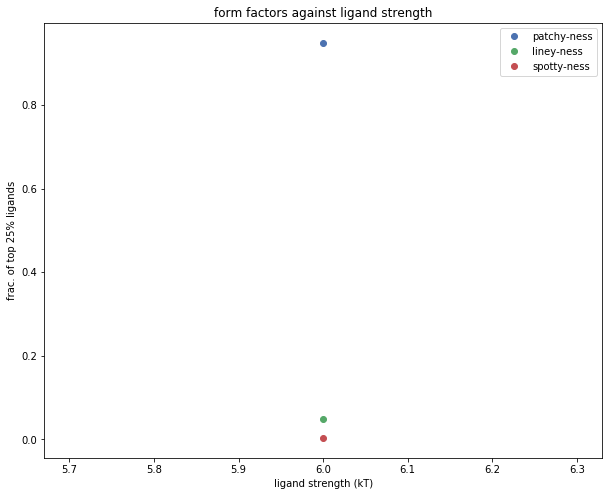

In [22]:
plt.plot([i[0] for i in fAllSorted],[i[1][0] for i in fAllSorted],'.',label='patchy-ness',markersize=12)
plt.plot([i[0] for i in fAllSorted],[i[1][1] for i in fAllSorted],'.',label='liney-ness',markersize=12)
plt.plot([i[0] for i in fAllSorted],[i[1][2] for i in fAllSorted],'.',label='spotty-ness',markersize=12)

plt.xlabel('ligand strength (kT)')
plt.ylabel('frac. of top 25% ligands')
plt.title('form factors against ligand strength')
plt.legend();

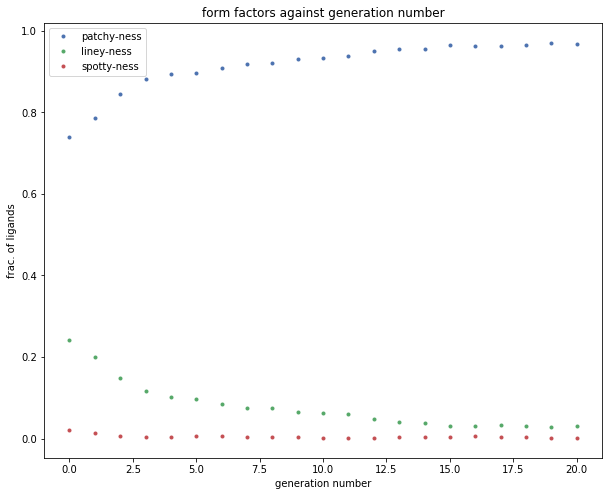

In [23]:
plt.plot([i[0] for i in avgFByG],[i[1][0] for i in avgFByG],'.',label='patchy-ness')
plt.plot([i[0] for i in avgFByG],[i[1][1] for i in avgFByG],'.',label='liney-ness')
plt.plot([i[0] for i in avgFByG],[i[1][2] for i in avgFByG],'.',label='spotty-ness')
plt.xlabel('generation number')
plt.ylabel('frac. of ligands')
plt.title('form factors against generation number')
plt.legend();

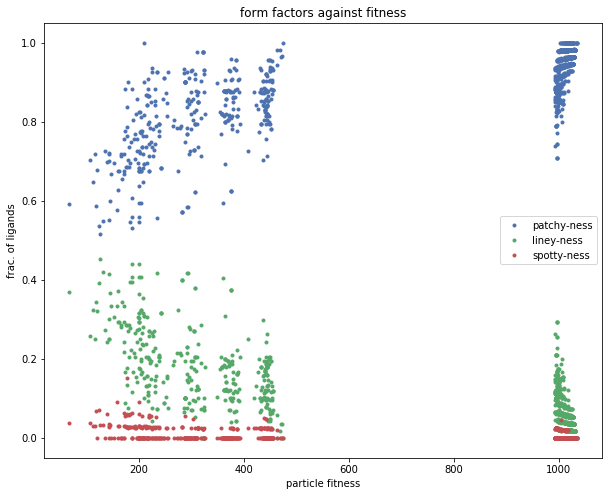

In [24]:
plt.plot([i[0] for i in formByFitness],[i[1][0] for i in formByFitness],'.',label='patchy-ness')
plt.plot([i[0] for i in formByFitness],[i[1][1] for i in formByFitness],'.',label='liney-ness')
plt.plot([i[0] for i in formByFitness],[i[1][2] for i in formByFitness],'.',label='spotty-ness')
plt.xlabel('particle fitness')
plt.ylabel('frac. of ligands')
axes = plt.gca()
plt.title('form factors against fitness')
plt.legend();

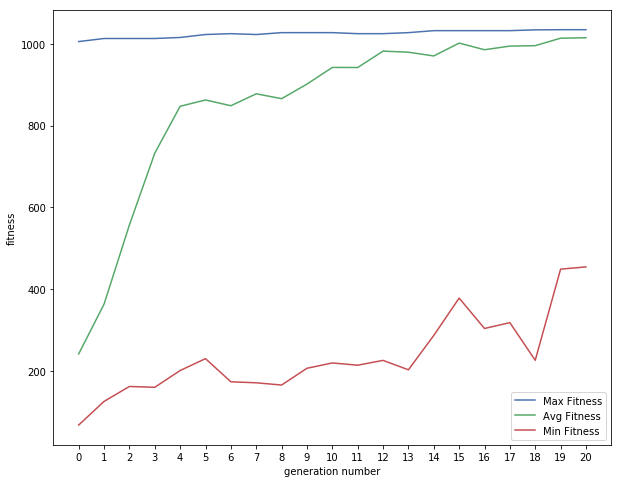

In [25]:
metrics = session.metrics.metricsPickle

metrics = np.array(metrics).flatten()


sortedMetrics = accumulateStats(sorted(sorted(metrics, key=lambda k: k['island']), key=lambda k: k['gen']) )


gens = [m['gen'] for m in sortedMetrics]
avg = [m['avg'] for m in sortedMetrics]
maxF = [m['max'] for m in sortedMetrics]
minF = [m['min'] for m in sortedMetrics]
std = [m['std'] for m in sortedMetrics]

xlim = 5

plt.figure()

plt.xticks(gens)

plt.plot(maxF,label='Max Fitness');
plt.plot(avg,label='Avg Fitness');
plt.plot(minF,label='Min Fitness');



plt.gca().relim()
plt.gca().autoscale(True)

#plt.gca().set_xlim(left=xlim-0.5)
#plt.gca().set_ylim(bottom=(avg[xlim]-minF[xlim])*0.5+minF[xlim] if xlim != 0 else 0)

plt.xlabel('generation number')
plt.ylabel('fitness')
plt.legend();

In [26]:
nets = []
for i in individuals:
    if i.fitness < 400:
        nets.append(buildPrunedNetworkView(i,0.5))
    if len(nets) > 7:
        break

netViews = nets[-1]
for n in range(len(nets)-1):
    netViews+=nets[n]
        
hv.ipython.display(netViews)

In [28]:
nets = []
for i in individuals:
    if i.fitness > 1000:
        nets.append(buildPrunedNetworkView(i,0.5))
    if len(nets) > 7:
        break

netViews = nets[-1]
for n in range(len(nets)-1):
    netViews+=nets[n]
        
hv.ipython.display(netViews)

In [29]:
networks = []
prunedNetworks = []
for i in individuals:
    n = buildLigandNetwork(i.phenomePickle.particle.ligands)
    networks.append((n,i))
    prunedNetworks.append((pruneNetwork(n,0.5),i))

In [30]:
minFit = 1e8
maxFit = 0
minNet = None
maxNet = None
minInd = None
maxInd = None

for n in networks:
    nFit = n[1].fitness
    if nFit<minFit:
        minFit = nFit
        minNet = n[0]
        minInd = n[1]
    if nFit>maxFit:
        maxFit = nFit
        maxNet = n[0]
        maxInd = n[1]

In [31]:
def gnmw(G):
    return(len(G.nodes()),len(G.edges()),np.sum([w['weight'] for (u,v,w) in G.edges(data=True)]))

In [32]:
def gnmRandomWeightedGraph(nodes,edges,weight):
    G = networkx.gnm_random_graph(nodes,edges)
    totalWeight = 0
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.uniform(0,10)
        totalWeight += w['weight']
    
    normFactor = weight/totalWeight
    
    for (u,v,w) in G.edges(data=True):
        w['weight'] = w['weight']*normFactor
        
    return G

In [33]:
def smallWorldNess(G):
    gnmwG = gnmw(G)
    RG = gnmRandomWeightedGraph(gnmwG[0],gnmwG[1],gnmwG[2])
    pLengthG = networkx.average_shortest_path_length(G,weight='weight')
    pLengthRG = networkx.average_shortest_path_length(RG,weight='weight')
    clusteringG = networkx.average_clustering(G,weight='weight')
    clusteringRG = networkx.average_clustering(RG,weight='weight')
    SW = (clusteringG/clusteringRG)/(pLengthG/pLengthRG)
    return SW

In [34]:
def plotTuples(tS,title="Graph",xlabel="x",ylabel="y"):
    x = [float(k[0]) for k in tS]
    y = [float(k[1]) for k in tS]
    plt.plot(x,y,'.')
    axes = plt.gca()
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [35]:
print minFit, maxFit

pruning = 0.0

prunedMin = pruneNetwork(minNet,pruning)
prunedMax = pruneNetwork(maxNet,pruning)

print smallWorldNess(prunedMin), smallWorldNess(prunedMax)

hv.ipython.display(buildNetworkView(prunedMin)+buildNetworkView(prunedMax))



makeParticleModel(minInd).display()
makeParticleModel(maxInd).display()


68.2500000000 1034.5833333333
0.3341727140017327 0.1740185502313138


Output()

Output()

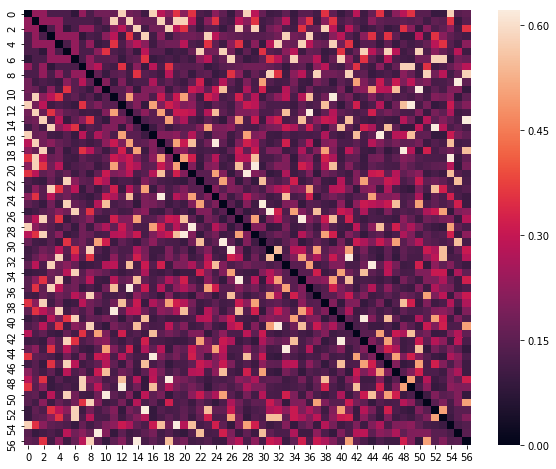

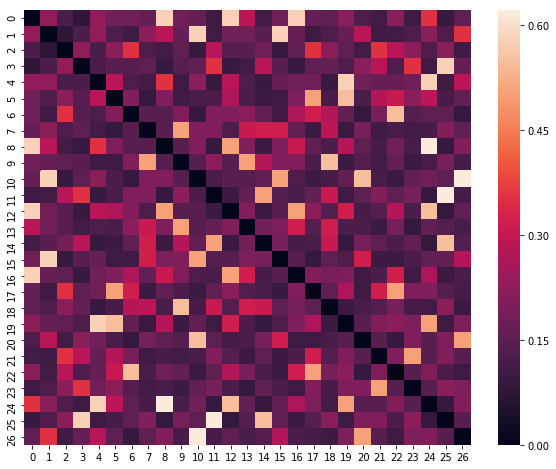

In [36]:
maxMat = networkx.adjacency_matrix(maxNet).todense()
minMat = networkx.adjacency_matrix(minNet).todense()
axMax = sns.heatmap(maxMat)
plt.show()
axMin = sns.heatmap(minMat)
plt.show()

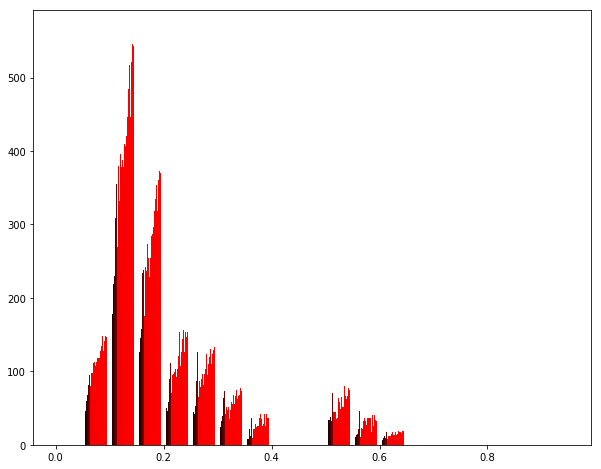

In [37]:
weights = []
maxF = 0
for n in random.sample(networks,250):
    iweights = []
    for e in n[0].edges:
        iweights.append(n[0].get_edge_data(*e)['weight'])
    f = n[1].fitness
    if f > maxF:
        maxF = f
    weights.append((iweights,f))
    
weights = sorted(weights, key=lambda tup: tup[1])
means = [(np.mean(w[0]),w[1]) for w in weights]
    
plt.hist([w[0] for w in weights],bins=np.arange(0.0,1.0,0.05),color=[(float(w[1]/maxF),0,0) for w in weights])
plt.show()

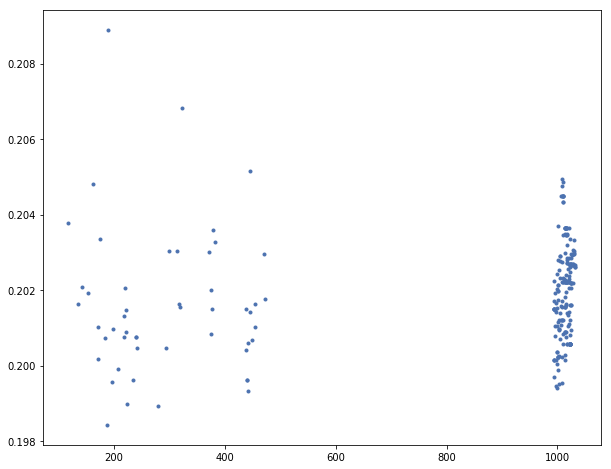

In [39]:
plt.plot([m[1] for m in means], [m[0] for m in means],'.')
plt.show()

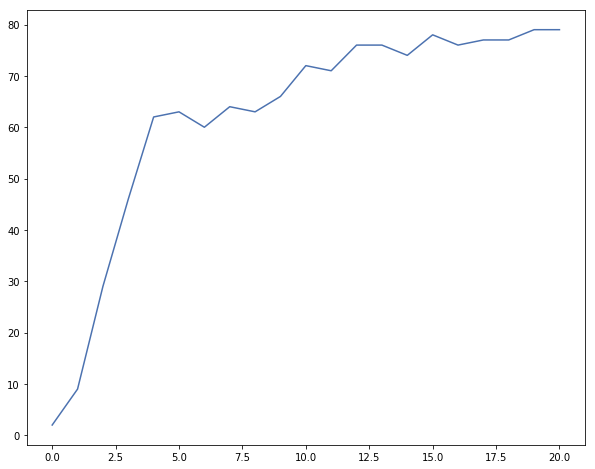

In [40]:
budded = [0]*len(session.generations)
for i in individuals:
    if i.fitness > 500:
        budded[i.gen.genNumber] += 1
plt.plot(budded)

In [41]:
# data = []
# for gen in session.generations:
#     data.append([])
#     j = 0
#     for g in gen.novelGenes:
#         data[i].append(0)
#         for ind in g.individuals:
#             if ind.gen == gen:
#                 data[i][j]+=1
#         j+=1
#     i += 1

In [42]:
def get_weight(path):
    return len(path)

In [43]:
print len(networks)

1680


In [44]:
maxPathFitness = []
for n in random.sample(prunedNetworks,1):
    G = n[0]
    i = n[1]
    maxPaths = []
    for ni in G.nodes():
        for nj in G.nodes():
            if ni<nj:
                npaths = list(networkx.all_simple_paths(G,ni,nj,len(G.nodes())))
                pathLengths = []
                for p in npaths:
                    if len(p) > 0:
                        pathLengths.append(get_weight(p))
                if len(pathLengths) > 0:
                    maxPaths.append(max(pathLengths))
    if len(maxPaths) > 0:
        maxPathFitness.append((i.fitness,max(maxPaths)))

KeyboardInterrupt: 

TypeError: expected non-empty vector for x

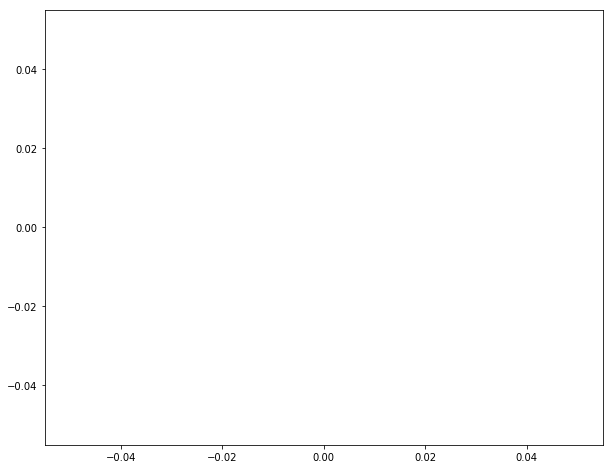

In [45]:
plotTuples(maxPathFitness)

In [46]:
cliqueFitness = []
cliqueBudtime = []

nodesFitness = []
nodesBudtime = []

avgDegreeFitness = []
avgDegreeBudtime = []

for n in prunedNetworks:
    G = n[0]
    i = n[1]
    nNodes = networkx.number_of_nodes(G)
    cliques = list(networkx.enumerate_all_cliques(G))
    avgDegree = networkx.average_degree_connectivity(G)
    maxPaths = []
    
    nCliques = networkx.graph_number_of_cliques(G)
    if i.fitness > 500:
        cliqueFitness.append((nCliques,float(i.fitness)))
        cliqueBudtime.append((nCliques,i.budTime))
        nodesFitness.append((nNodes,float(i.fitness)))
        nodesBudtime.append((nNodes,i.budTime))
        avgDegreeFitness.append((avgDegree,float(i.fitness)))
        avgDegreeBudtime.append((avgDegree,i.budTime))
    



In [47]:
avgDegreeSorted = []
avgDegreeBudSorted = []

for i in range(10):
    avgDegreeSorted.append([])
    avgDegreeBudSorted.append([])
    for df in avgDegreeFitness:
        if i in df[0]:
            avgDegreeSorted[i].append((i,df[0][i], df[1]))
    for df in avgDegreeBudtime:
        if i in df[0]:
            avgDegreeBudSorted[i].append((i,df[0][i], df[1]))

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


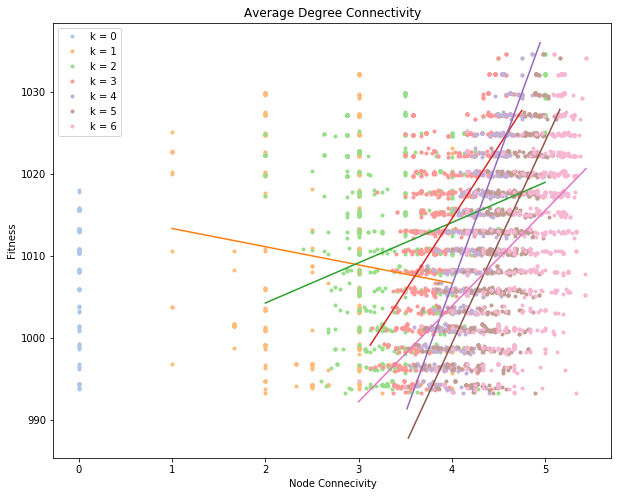

In [59]:
plt.xlabel("Node Connecivity")
plt.ylabel("Fitness")
plt.title("Average Degree Connectivity")
for i in range(len(avgDegreeSorted)):
    x = [float(k[1]) for k in avgDegreeSorted[i]]
    y = [float(k[2]) for k in avgDegreeSorted[i]]
    if len(x) > 0:
        plt.plot(x,y,'.',label = 'k = %s'%i,color=plt.cm.tab20(i*2+1))
for i in range(len(avgDegreeSorted)):
    x = [float(k[1]) for k in avgDegreeSorted[i]]
    y = [float(k[2]) for k in avgDegreeSorted[i]]
    if len(x) > 0:
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color=plt.cm.tab20(i*2))
plt.legend()
plt.show()

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


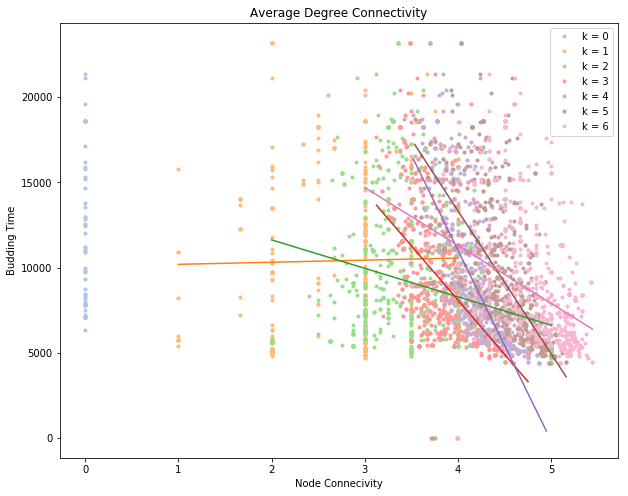

In [67]:
plt.xlabel("Node Connecivity")
plt.ylabel("Budding Time")
plt.title("Average Degree Connectivity")
for i in range(len(avgDegreeSorted)):
    x = [float(k[1]) for k in avgDegreeBudSorted[i]]
    y = [float(k[2]) for k in avgDegreeBudSorted[i]]
    if len(x) > 0:
        plt.plot(x,y,'.',label = 'k = %s'%i,color=plt.cm.tab20(i*2+1))
for i in range(len(avgDegreeSorted)):
    x = [float(k[1]) for k in avgDegreeBudSorted[i]]
    y = [float(k[2]) for k in avgDegreeBudSorted[i]]
    if len(x) > 0:
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color=plt.cm.tab20(i*2))
plt.legend()
plt.show()

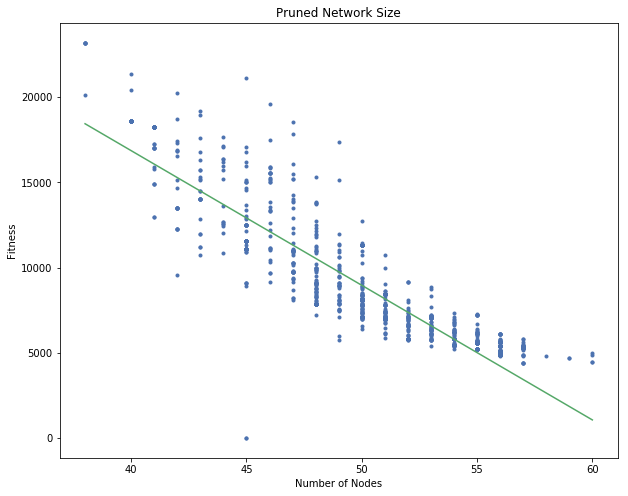

In [60]:
plotTuples(nodesBudtime,"Pruned Network Size","Number of Nodes","Fitness")

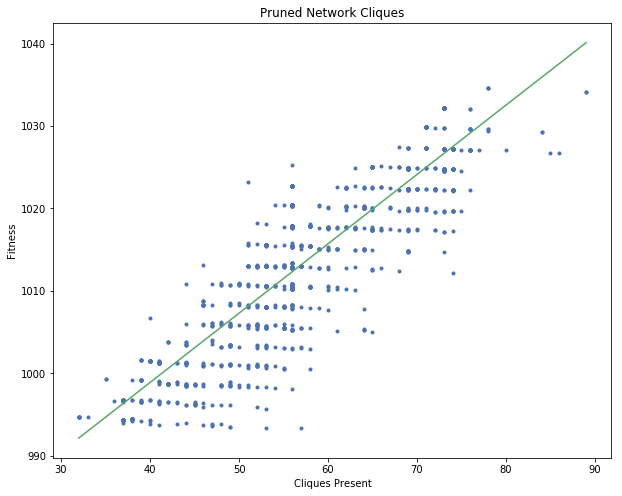

In [61]:
plotTuples(cliqueFitness,"Pruned Network Cliques","Cliques Present","Fitness")

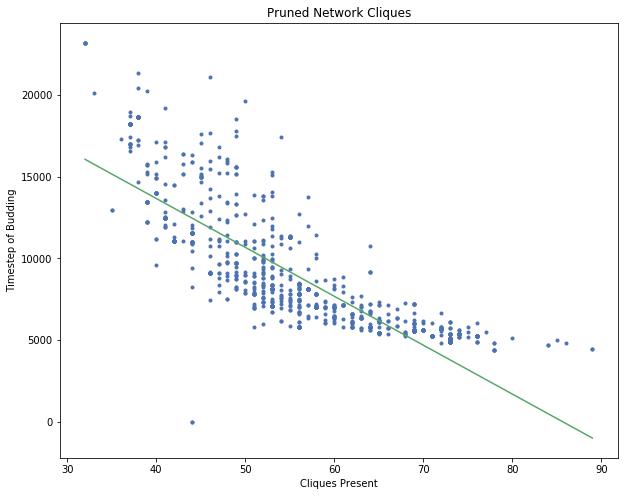

In [62]:
plotTuples(cliqueBudtime,"Pruned Network Cliques","Cliques Present","Timestep of Budding")

In [63]:
sortedBySize = {}

for n in prunedNetworks:
    G = n[0]
    i = n[1]
    nNodes = networkx.number_of_nodes(G)
    if not nNodes in sortedBySize:
        sortedBySize[nNodes] = []
        sortedBySize[nNodes].append((G,i))
    else:
        sortedBySize[nNodes].append((G,i))

minDist = 1000
targetSet = 40
maxSet = []
chosenSet = -1
for k,v in sortedBySize.iteritems():
    if abs(k - targetSet) < minDist:
        minDist = abs(k - targetSet)
        maxSet = v
        chosenSet = k


pureCliqueFitness = {}
pureCliqueBudtime = {}
        
for k,v in sortedBySize.iteritems():
    pureCliqueFitness[k] = []
    pureCliqueBudtime[k] = []
    for n in v:
        G = n[0]
        i = n[1]
        if i.fitness > 500:
            pureCliques = list(networkx.enumerate_all_cliques(G))
            nCliques = networkx.graph_number_of_cliques(G)
            pureCliqueFitness[k].append((nCliques,float(i.fitness)))
            pureCliqueBudtime[k].append((nCliques,i.budTime))

maxSetViews = buildNetworkView(maxSet[0][0])
for n in maxSet[1:]:
    maxSetViews+=buildNetworkView(n[0])


# hv.ipython.display(maxSetViews)
    

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


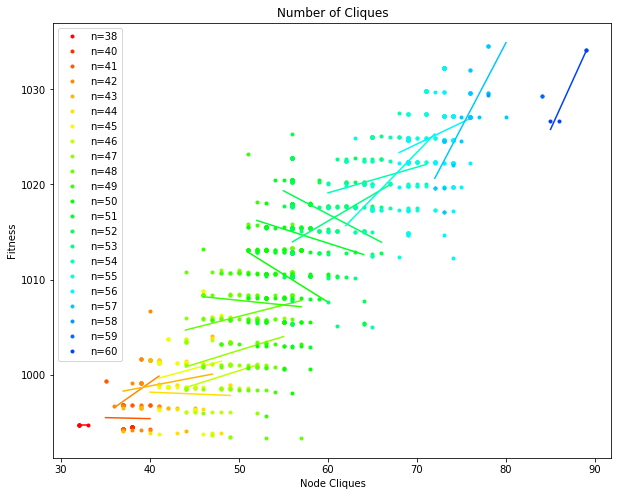

In [84]:
plt.xlabel("Node Cliques")
plt.ylabel("Fitness")
plt.title("Number of Cliques")
colors = hsv(np.linspace(0, 1.0, len(pureCliqueFitness)))
i = 0
for key,v in pureCliqueFitness.iteritems():
    x = [float(k[0]) for k in v]
    y = [float(k[1]) for k in v]
    if len(x) > 0:
        plt.plot(x,y,'.',label = 'n=%s'%key,color=colors[i])
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color=colors[i])
        i+=1
plt.legend()
plt.show()

/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/Users/joelforster/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


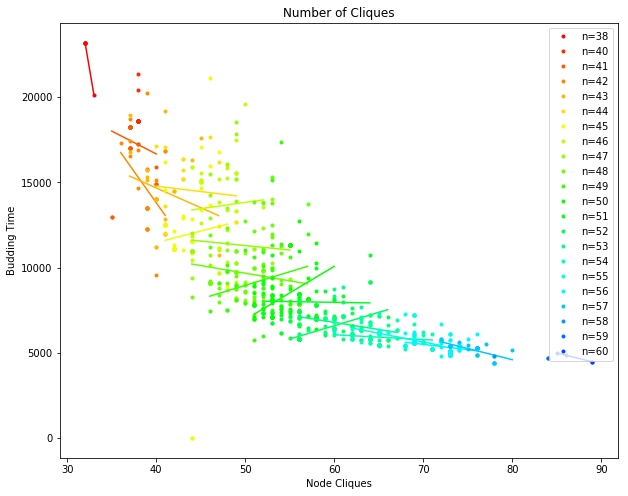

In [83]:
plt.xlabel("Node Cliques")
plt.ylabel("Budding Time")
plt.title("Number of Cliques")
colors = hsv(np.linspace(0, 1.0, len(pureCliqueFitness)))
i = 0
for key,v in pureCliqueBudtime.iteritems():
    x = [float(k[0]) for k in v]
    y = [float(k[1]) for k in v]
    if len(x) > 0:
        plt.plot(x,y,'.',label = 'n=%s'%key,color=colors[i])
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color=colors[i])
        i+=1
plt.legend()
plt.show()

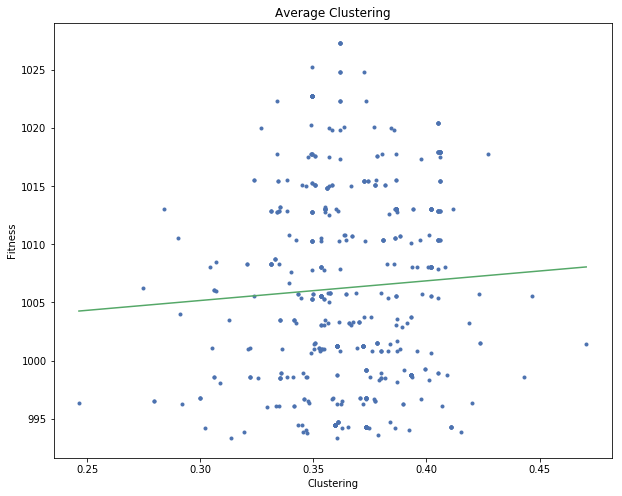

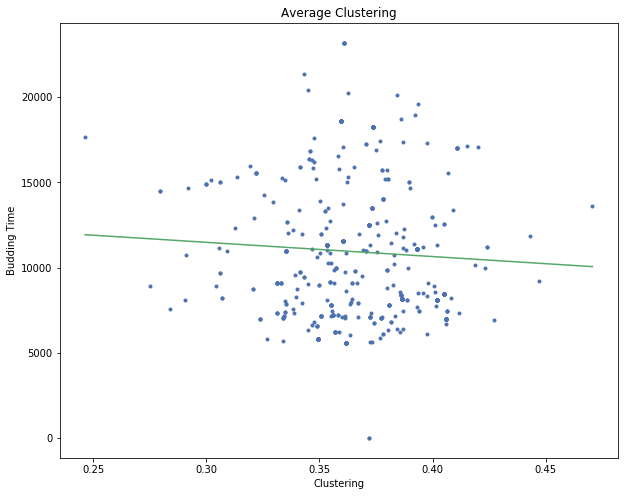

In [263]:
cpFitness = []
cpBudtime = []

for n in prunedNetworks:
    G = n[0]
    i = n[1]
    c = networkx.average_clustering(G,weight='weight')
    if i.fitness > 500:
        cpFitness.append((c,i.fitness))
        cpBudtime.append((c,i.budTime))
    
plotTuples(cpFitness,"Average Clustering","Clustering","Fitness")
plotTuples(cpBudtime,"Average Clustering","Clustering","Budding Time")

In [100]:
cFitness = []
cSW = []
cNL = []

for n in random.sample(networks,200):
    
    G = n[0]
    i = n[1]
    #clustering = networkx.clustering(G,weight='weight')
    c = networkx.average_clustering(G,weight='weight')
    sw = smallWorldNess(G)
    cFitness.append((i.fitness,c))
    cSW.append((i.fitness,sw))
    cNL.append((len(G.nodes()),sw))

    
#     knn = networkx.k_nearest_neighbors(G, weight='weight')
#     knearest.append((i['fitness'],knn))
    


In [ ]:
x = [float(k[0]) for k in cNL]
y = [float(k[1]) for k in cNL]
plt.plot(x,y,'.')
axes = plt.gca()
#axes.set_xlim(550,570)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('Network Size')
plt.ylabel('Small World Coefficient')
plt.title('Small Worldiness')
plt.show()

In [ ]:
cSWfilter = list(filter(lambda l: l[0] > 400,cSW))

x = [float(k[0]) for k in cSWfilter]
y = [float(k[1]) for k in cSWfilter]
plt.plot(x,y,'.')
axes = plt.gca()
#axes.set_xlim(550,570)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('Particle Fitness')
plt.ylabel('Small World Coefficient')
plt.title('Small Worldiness')
plt.show()

In [ ]:
cFitnessFil = list(filter(lambda l: l[0] > 500,cFitness))

x = [float(k[0]) for k in cFitnessFil]
y = [float(k[1]) for k in cFitnessFil]

plt.plot(x,y,'.')

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
axes = plt.gca()
#axes.set_xlim(500)
plt.xlabel('Particle Fitness')
plt.ylabel('Average Clustering Coefficient')
plt.title('Average Clustering Coefficient of Ligand Spacing Network')
plt.show()

In [ ]:
fitDiff = []
hamming = []

for i in individuals:
    for j in individuals:
        if i!=j:
            fitDiff.append(abs(getFitness(i)-getFitness(j)))
            hamming.append(hammingDistance(i.genome,j.genome))
            
plt.figure()
plt.plot(hamming,fitDiff,'.')
plt.ylabel('Fitness Difference')
plt.xlabel('Hamming Distance')
plt.title('Fitness difference of Particles Against Hamming Distance')
plt.show()

In [ ]:
generations = session.generations
genes = session.getGenesList()

xticks = [str(g.pID) for g in genes]

data = []

i = 0

for gen in generations:
    data.append([])
    j = 0
    for g in genes:
        data[i].append(0)
        for ind in g.individuals:
            if ind.gen == gen:
                data[i][j]+=1
        j+=1
    i += 1

In [ ]:
ax = sns.heatmap(data)

In [ ]:
geneIncidence = [0]*len(data[-1])
for d in data:
    for i in range(len(geneIncidence)):
        geneIncidence[i] += d[i]
dataReduced = []
xTicks = []
for i in range(len(geneIncidence)):
    if geneIncidence[i] > 10:
        xTicks.append(i)

for i in range(len(data)):
    dataReduced.append([])
    for j in xTicks:
        dataReduced[i].append(data[i][j])


In [ ]:

colormap = sns.cubehelix_palette(as_cmap=True)
sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(dataReduced,
                 vmin=-0.05,cmap=colormap)

In [25]:
import smallworld as sw

In [33]:
SWG = sw.createSmallWorldLigandNetwork(25,0.1)
print sw.smallWorldNess(SWG)
hv.ipython.display(buildNetworkView(SWG))

0.36539572387041824


In [34]:
SWP = buildNanoParticleFromNetwork(SWG,8)
p = makeParticleModelFromPhenome(SWP)
display(p)

UGxvdChhbnRpYWxpYXM9VHJ1ZSwgYmFja2dyb3VuZF9jb2xvcj0xNjc3NzIxNSwgZ3JpZD1bLTEsIC0xLCAtMSwgMSwgMSwgMV0sIGhlaWdodD01MTIsIG9iamVjdF9pZHM9WzEyMTAxNTM2MTDigKY=


In [35]:
sim = MembraneSimulation(
    'sim_SWP',
    SWP,
    50000,
    0.01,        
    '/Users/joel/Desktop',
    '/Users/joel/Desktop',
    '/Users/joel/Projects/emergent-optimiser/mem/template/data.template',
    '/Users/joel/Projects/emergent-optimiser/mem/template/in.template',
    rAxis=vectools.randomUnitVector(),
    rAmount=random.uniform(0.3141,3.141)
)
sim.saveFiles()

In [87]:
sims = []

from sqlalchemy import *
from sqlalchemy.orm import *

engine = create_engine('sqlite:////Users/joelforster/Projects/optidb/july/6-24/datastore.db')
Session = sessionmaker()
Session.configure(bind=engine)
session = Session()

qr = session.query(dbc.Simulation)

sims = [r for r in qr]


In [89]:
budPlot = []

i = 0
for s in sims:
    budPlot.append([])
    f = s.individual[-1].fitness
    ff = formFactor(s.individual[-1].phenomePickle.particle.ligands)
    for step in s.data:
        if random.uniform(0.0,1.0)<0.25:
            budPlot[i].append((step['timestep'], step['coverage'], step['budded'],f,ff))
    i+=1
sims = []

In [360]:
def lighter(color, percent):
    '''assumes color is rgb between (0, 0, 0) and (255, 255, 255)'''
    color = np.array(color)
    white = np.array([1.0, 1.0, 1.0])
    vector = white-color
    return color + vector * percent

In [119]:
minBud = 1e8
maxBud = 0
bRange = []
for b in budPlot:
    if b[-1][3]<minBud:
        minBud = b[-1][3]
    if b[-1][3]>maxBud:
        maxBud = b[-1][3]
    bRange.append(int(b[-1][3]))

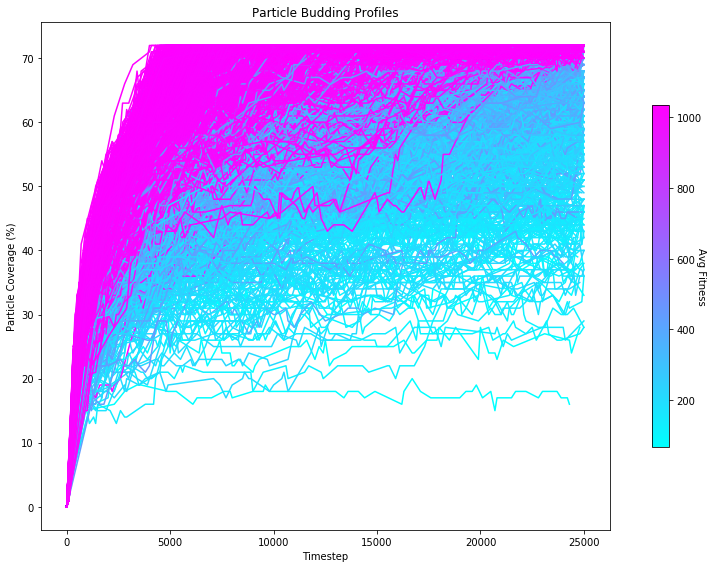

In [288]:
from matplotlib import gridspec

fig, axes = plt.subplots(
        nrows=1, ncols=2, 
        gridspec_kw={'width_ratios':[5,1]}
        )
ax0 = axes[0]
ax1 = axes[1]
ax0.set_xlabel("Timestep")
ax0.set_ylabel("Particle Coverage (%)")
ax0.set_title("Particle Budding Profiles")

colors = cool(np.linspace(0, 1.0, int(maxBud-minBud)+1))
for i in range(len(budPlot)):
    x = [float(k[0]) for k in budPlot[i]]
    y = [float(k[1]) for k in budPlot[i]]
    f = float(budPlot[i][-1][3])
    if len(x) > 0:
        ax0.plot(x,y, color=colors[int(f)-int(minBud)])
        
plt.imshow(I, cmap=cool)
cbar = plt.colorbar()
cbar.set_label('Avg Fitness', rotation=270)
plt.gca().set_visible(False)
plt.clim(int(minBud),int( maxBud));
plt.tight_layout()
